**Before starting:**

You need to install Basemap. Do it only once.

In [ ]:
!pip install basemap

In [ ]:
!pip install matplotlib-label-lines

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [ ]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(20,20) # graph size
from labellines import labelLines
import statistics

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [ ]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<150:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='ortho',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)

# function to plot time series
def plot_ts(time,ts,line_type,var_name,label):

    # plot
    plot_date(time,ts,line_type,label=label)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. using the following command. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2022". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr or on Discord.

In [ ]:
from google.colab import auth
auth.authenticate_user()

#**DESCRIPTION**

**The important role of Niño events**

"Le phénomène climatique El Niño/la Niña, l’oscillation qui influence fortement les températures de surface de l’Océan Pacifique tropical continue de marquer l’évolution pluriannuelle des température et surimpose sa signature sur la tendance semi-séculaire de réchauffement dû à nos émissions de gaz à effet de serre."
https://www.lemonde.fr/blog/huet/2022/01/13/5082/

In [ ]:
%%bigquery --project alert-ground-261008 output_2
SELECT time, AVG(ssh) as mean_ssh,AVG(sst) as mean_sst
FROM bdo2020.bdo2020.1998_2015
GROUP BY time
ORDER BY time

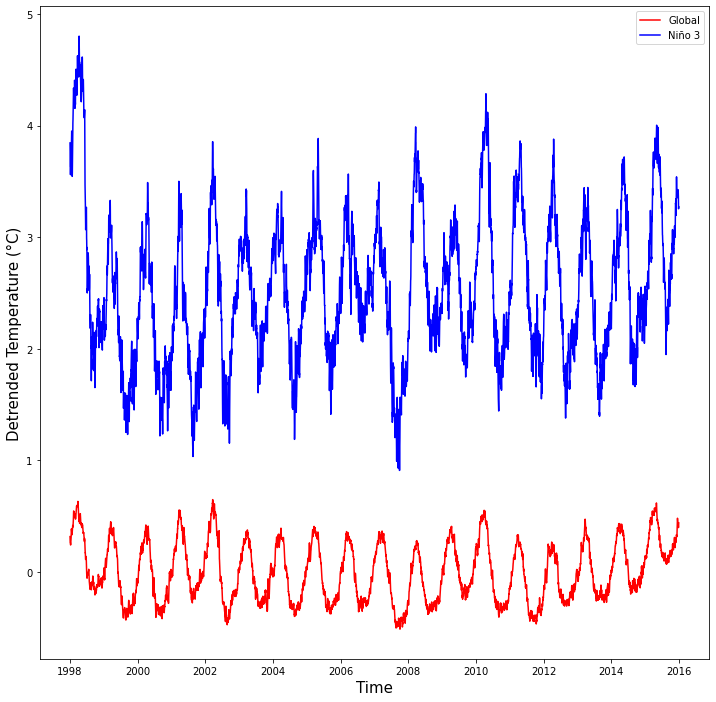

In [ ]:
figsize(12,12)
plot_ts(output_2.time,output_2.mean_sst-output_2.mean_sst.mean(),'r-',"","Global")
plot_ts(output_2.time,output_3.mean_sst-output_2.mean_sst.mean(),'b-',"Detrended Temperature (°C)","Niño 3")
legend()

The data, there, is inconsistent, it is impossible that during the year 2002 the global SST dropped by 8°C.

In [ ]:
%%bigquery --project alert-ground-261008 before_2003
SELECT MAX(lon) as max_lon,MIN(lon) as min_lon,MAX(lat) as max_lat,MIN(lat) as min_lat
FROM `bdo2020.bdo2020.1998_2015_withtimes` 
WHERE year<2002

In [ ]:
before_2003

,max_lon,min_lon,max_lat,min_lat
0,359.875,0.125,39.375,-39.125


In [ ]:
%%bigquery --project alert-ground-261008 after_2003
SELECT MAX(lon) as max_lon,MIN(lon) as min_lon,MAX(lat) as max_lat,MIN(lat) as min_lat
FROM `bdo2020.bdo2020.1998_2015_withtimes` 
WHERE year>2004

In [ ]:
after_2003

,max_lon,min_lon,max_lat,min_lat
0,359.875,0.125,84.375,-78.375


It seems that this inconsistency is due to a change in the measurements made...
After 2002, measurements started to be taken on the whole globe, including the poles and logically lowering the global temperature.

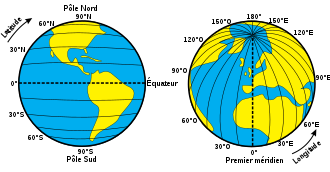

In [ ]:
from IPython.display import Image
Image('langfr-330px-Latitude_and_Longitude_of_the_Earth_fr.svg.png')

In [ ]:
%%bigquery --project alert-ground-261008 output_2
SELECT time, AVG(ssh) as mean_ssh,AVG(sst) as mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lat<40 AND lat>-40
GROUP BY time
ORDER BY time

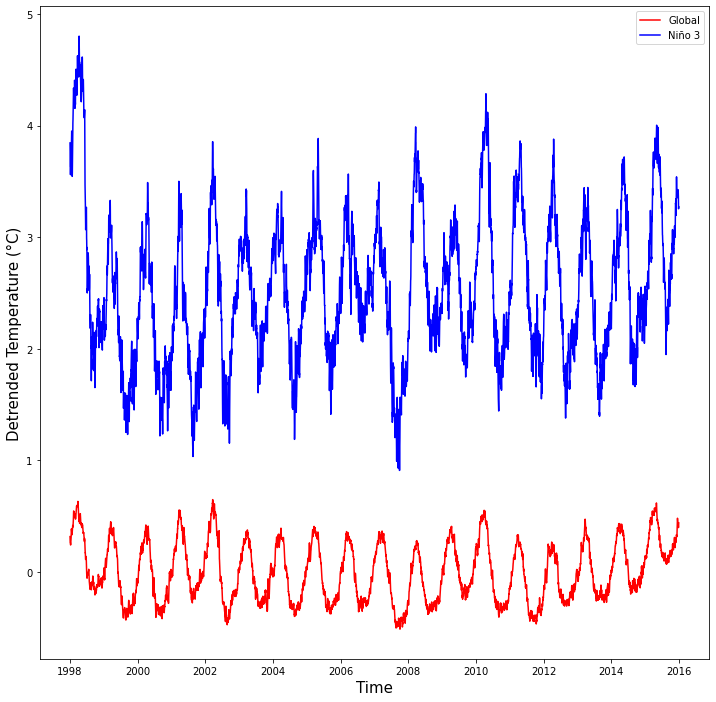

In [ ]:
figsize(12,12)
plot_ts(output_2.time,output_2.mean_sst-output_2.mean_sst.mean(),'r-',"","Global")
plot_ts(output_2.time,output_3.mean_sst-output_2.mean_sst.mean(),'b-',"Detrended Temperature (°C)","Niño 3")
legend()

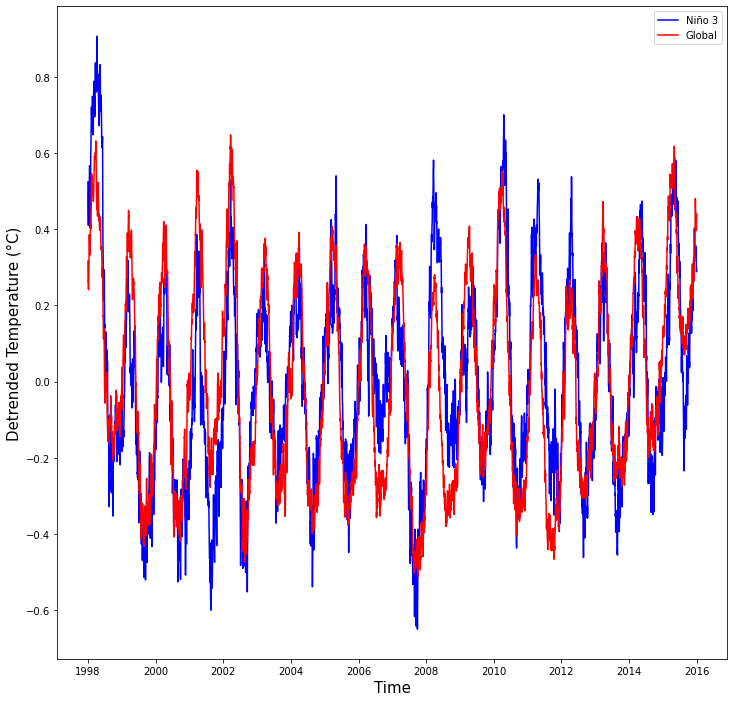

In [ ]:
figsize(12,12)
plot_ts(output_2.time,0.4*(output_3.mean_sst-output_3.mean_sst.mean()),'b-',"","Niño 3")
plot_ts(output_2.time,output_2.mean_sst-output_2.mean_sst.mean(),'r-',"Detrended Temperature (°C)","Global")
legend()

**Plot maps of sst and ssh in the region several months before ENSO events**

---

**El Niña example**

"Depuis le début de l'année 2007, un épisode modéré de La Niña se produit dans le Pacifique équatorial. Après s'être un temps interrompu en mars-mai 2007, cet évènement persiste en début d'hiver 2007-2008 et devrait perdurer jusqu'au printemps 2008. Les températures relévées au début du mois de janvier 2008 sont de 1.5°C plus froides que la normale. Voir Balades en LAS, 23 janvier 2008 : La Niña, quand le courant bascule vers l'ouest."
https://www.aviso.altimetry.fr/fr/applications/climat/el-nino/chronologie-des-evenements-depuis-1992.html

Retrieve and plot the sst and ssh maps over the period : january to march 2007

In [ ]:
%%bigquery --project alert-ground-261008 output4
SELECT lon, lat, AVG(sst) AS mean_sst,AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20 AND 1<=month AND month<4 AND year=2007
GROUP BY lat, lon

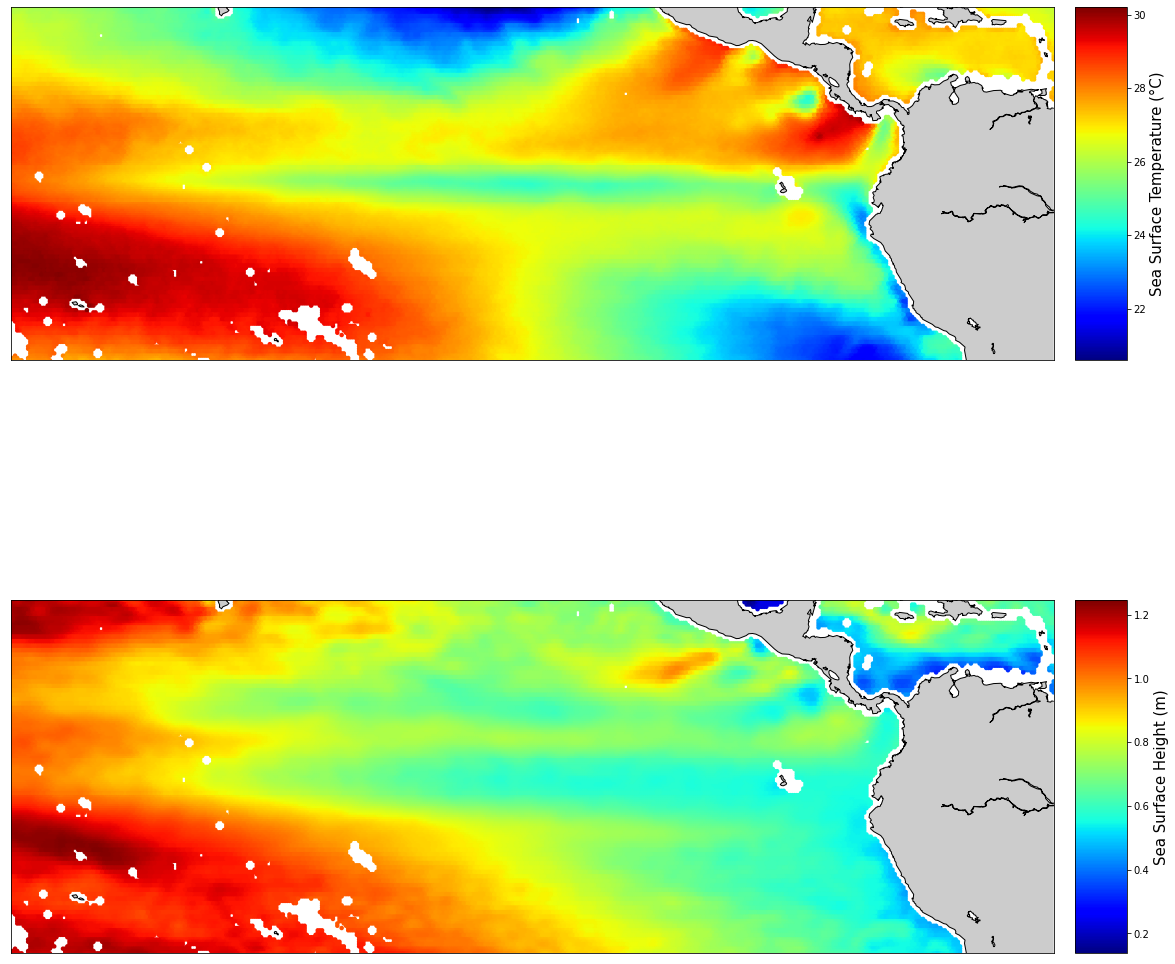

In [ ]:
figure()
figsize(30,20)
subplot(2,1,1)
plot_im(output4.lon,output4.lat,output4.mean_sst,20,'Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_im(output4.lon,output4.lat,output4.mean_ssh,20,'Sea Surface Height (m)')

We can see above SST and SSH maps of the Niño 3 region several months previous a moderate Niña event.

**El Niño example**



"Un épisode El Niño est annoncé en mai 2015, et prédit comme étant propablement un épisode fort. Les cartes issues des mesures altimétriques, les hauteurs de mer montrent de grandes zones avec des anomalies positives dans le Pacifique équatorial. A la même époque, les températures de surface sont aussi plus chaudes que la normale. Durant l'été 2015, cette eau chaude s'étend vers le centre-est de l'océan Pacifique. Ces conditions ressemblent fortement aux conditions de l'épisode El Niño de 1987, épisode de très forte intensité."
https://www.aviso.altimetry.fr/fr/applications/climat/el-nino/chronologie-des-evenements-depuis-1992.html 

En 2015, El Niño est si fort que les météorologues américains le renomment par dérision « Bruce Lee ».
https://fr.wikipedia.org/wiki/El_Ni%C3%B1o 

In [ ]:
%%bigquery --project alert-ground-261008 output5
SELECT lon, lat, AVG(sst) AS mean_sst,AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20 AND month=5 AND year=2015
GROUP BY lat, lon

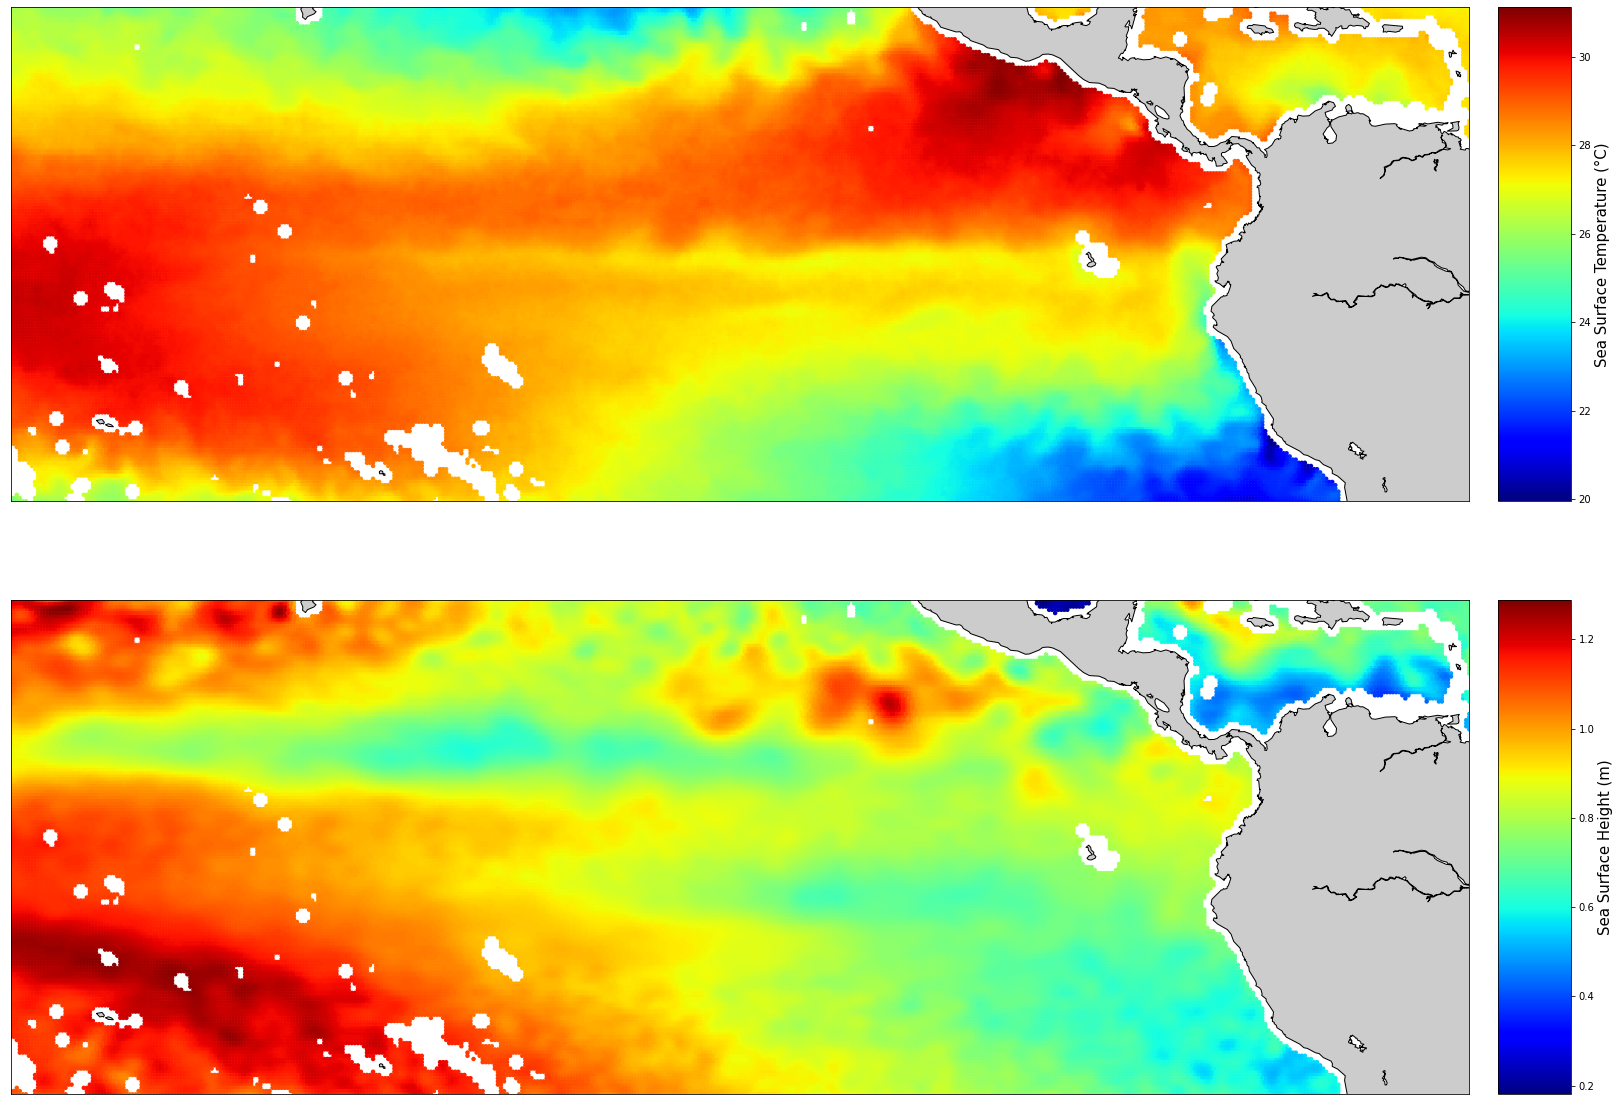

In [ ]:
figure()
figsize(30,20)
subplot(2,1,1)
plot_im(output5.lon,output5.lat,output5.mean_sst,20,'Sea Surface Temperature (°C)')
subplot(2,1,2)
plot_im(output5.lon,output5.lat,output5.mean_ssh,20,'Sea Surface Height (m)')

We can see above SST and SSH maps of the Niño 3 region several months previous a strong Niño event.

**Retrieving data for Niño 3**

Niño 3 : region  5°N-5°S, 90°-
150°W


In [ ]:
%%bigquery --project alert-ground-261008 output_3
SELECT time, AVG(ssh) as mean_ssh,AVG(sst) as mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY time
ORDER BY time

In [ ]:
global_mean_sst = output_3.mean_sst.mean()
global_mean_sst - output_2.mean_sst.mean()

2.205033996680246

**Plot time serie of the SST daily mean over the Niño 3 region from 1998 to 2016**

[Text(2000-08-20 11:24:00, 0.4, 'Weak'),
 Text(2003-03-08 02:02:24, -0.4, 'Weak'),
 Text(2005-09-22 16:40:48, 0.8, 'Moderate'),
 Text(2008-04-09 07:19:12, -0.8, 'Moderate'),
 Text(2010-10-25 21:57:36, 1.2000000000000002, 'Strong'),
 Text(2013-05-12 12:36:00, -1.2000000000000002, 'Strong')]

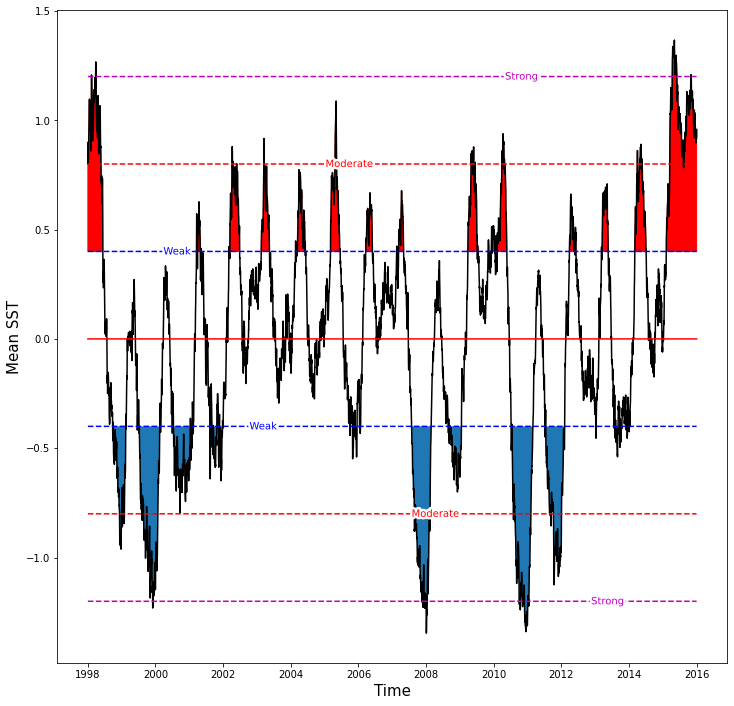

In [ ]:
time = output_3.time
y = output_3.mean_sst-global_mean_sst
n = output_3.shape[0]
upper_born = 0.4*np.ones(n)
origin = np.zeros(n)
lower_born = -0.4*np.ones(n)

figsize(12,12)
plot_ts(time,y,'k-',"","")
fill_between(time,y, upper_born,where=y>upper_born , color='r')
fill_between(time,y, lower_born,where=y<lower_born)
plot_ts(time,origin,'r-',"","")
plot_ts(time,upper_born,'b--',"",label="Weak")
plot_ts(time,lower_born,'b--',"",label="Weak")
plot_ts(time,2*upper_born,'r--',"",label="Moderate")
plot_ts(time,2*lower_born,'r--',"",label="Moderate")
plot_ts(time,3*upper_born,'m--',"",label="Strong")
plot_ts(time,3*lower_born,'m--',"Mean SST",label="Strong")

labelLines(gca().get_lines())

**Compute and plot the 5 months running mean on this zone :**

In [ ]:
moving_average_mean_sst = output_3.mean_sst.rolling(150, min_periods=1,win_type="gaussian").mean(std=10)

[Text(2000-08-20 11:24:00, 0.4, 'Weak'),
 Text(2003-03-08 02:02:24, -0.4, 'Weak'),
 Text(2005-09-22 16:40:48, 0.8, 'Moderate'),
 Text(2008-04-09 07:19:12, -0.8, 'Moderate'),
 Text(2010-10-25 21:57:36, 1.2000000000000002, 'Strong'),
 Text(2013-05-12 12:36:00, -1.2000000000000002, 'Strong')]

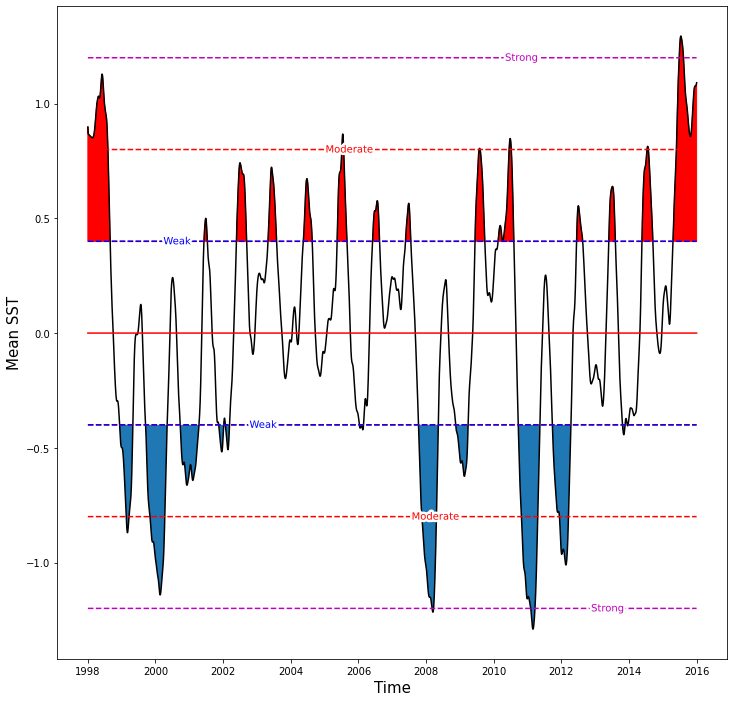

In [ ]:
y = moving_average_mean_sst-global_mean_sst
n = output_3.shape[0]
upper_born = 0.4*np.ones(n)
origin = np.zeros(n)
lower_born = -0.4*np.ones(n)

figsize(12,12)
plot_ts(time,y,'k-',"","")
fill_between(time,y, upper_born,where=y>upper_born , color='r')
fill_between(time,y, lower_born,where=y<lower_born)
plot_ts(time,origin,'r-',"","")
plot_ts(time,upper_born,'r--',"","")
plot_ts(time,lower_born,'r--',"5 months SST running mean","")
plot_ts(time,upper_born,'b--',"",label="Weak")
plot_ts(time,lower_born,'b--',"",label="Weak")
plot_ts(time,2*upper_born,'r--',"",label="Moderate")
plot_ts(time,2*lower_born,'r--',"",label="Moderate")
plot_ts(time,3*upper_born,'m--',"",label="Strong")
plot_ts(time,3*lower_born,'m--',"Mean SST",label="Strong")

labelLines(gca().get_lines())

**Histogram and distribution anomalies plots**

In [ ]:
%%bigquery --project alert-ground-261008 test
SELECT month,year, AVG(sst) as mean_sst, AVG(ssh) AS mean_ssh, time
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>180 AND lon<300 AND lat>-20 AND lat<20
GROUP BY month,year, time
ORDER BY year,month

In [ ]:
Ninoext = test.loc[(test["month"] < 7) & (test["year"] == 1998)]
Ninoext
Ninaext = test.loc[((test["month"] >= 11 ) & (test["year"] == 2010)) | ((test["month"] <= 4 ) & (test["year"] == 2011))]
Ninaext

,month,year,mean_sst,mean_ssh,time
4686,11,2010,25.188418,0.771738,734093.0
4687,11,2010,25.229818,0.770211,734101.0
4688,11,2010,25.169013,0.775930,734088.0
4689,11,2010,25.161717,0.770956,734104.0
4690,11,2010,25.202207,0.773871,734090.0
...,...,...,...,...,...
4862,4,2011,26.683061,0.789466,734254.0
4863,4,2011,26.494307,0.787799,734230.0
4864,4,2011,26.580089,0.787376,734236.0
4865,4,2011,26.517848,0.788011,734231.0


SST

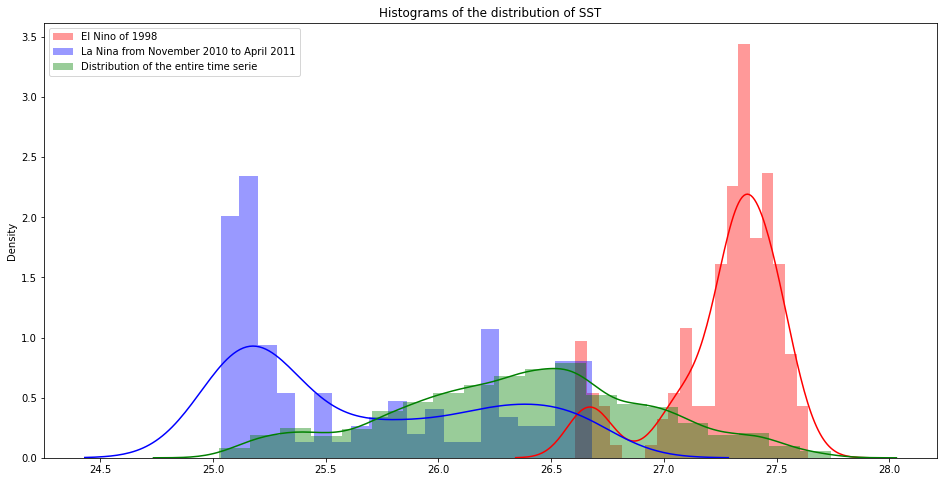

In [ ]:
figure(figsize = (16,8))
sns.distplot(Ninoext, x = Ninoext.mean_sst, kde = True, label = "El Nino of 1998", bins= 20, color="red")
sns.distplot(Ninaext, x= Ninaext.mean_sst, kde = True, label= "La Nina from November 2010 to April 2011", bins = 20, color="blue")
sns.distplot(Ninoext, x = test.mean_sst, kde = True, label = "Distribution of the entire time serie", bins = 20, color="green").set(title = "Histograms of the distribution of SST")
legend()

*SSH*

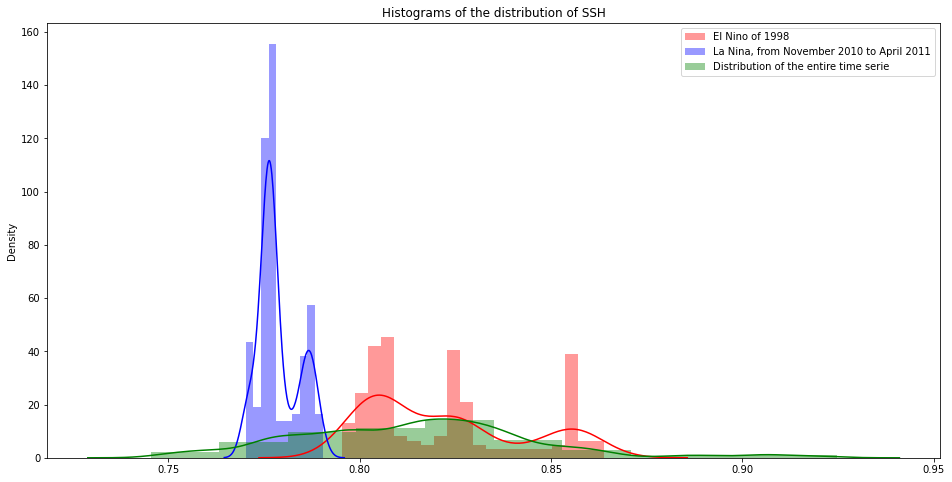

In [ ]:
figure(figsize = (16,8))
sns.distplot(Ninoext, x = Ninoext.mean_ssh, kde = True, label = "El Nino of 1998", bins = 20, color= "red")
sns.distplot(Ninaext, x= Ninaext.mean_ssh, kde = True, label= "La Nina, from November 2010 to April 2011", bins = 10, color="blue")
sns.distplot(Ninoext, x = test.mean_ssh, kde = True, label = "Distribution of the entire time serie", bins = 10, color= "green").set(title = "Histograms of the distribution of SSH")
legend()

**Compute the derivative of the 5 months running mean and plot the phase portrait of the SST**

In [ ]:
mean_sst_deriv = (diff(moving_average_mean_sst))/(diff(output_3.time))

Text(0, 0.5, 'dSST/dt')

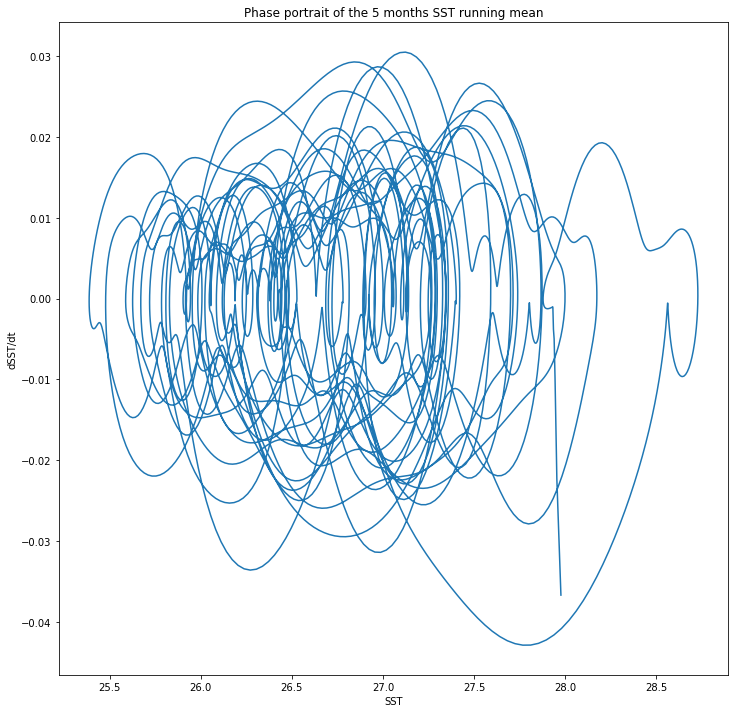

In [ ]:
plot(moving_average_mean_sst[1:],mean_sst_deriv)
title("Phase portrait of the 5 months SST running mean")
xlabel("SST")
ylabel("dSST/dt")

Construction of the GIF 

In [ ]:
%%bigquery --project alert-ground-261008 output_3
SELECT time, year, month, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>=180 AND lon<=300 AND lat>=-20 AND lat<=20
GROUP BY time, year, month
ORDER BY time

In [ ]:
## The error is not an issue for the following codes
filenames=[]
n = output_3.shape[0]
id_month = np.zeros(n)

for i in range(0,n):
  id_month[i] = (output_3.time[i]-729390.0)/30%12+1
print(type(id_month))
moving_average_mean_sst = output_3.mean_sst.rolling(150, center=True, min_periods=1, win_type="gaussian").mean(std=10)
mean_sst_deriv = (diff(moving_average_mean_sst))/diff(output_3.time)

for i in range(0,n-4,30):
  scatter(moving_average_mean_sst[i:i+180],mean_sst_deriv[i:i+180],c=id_month[i:i+180], cmap='twilight_shifted', vmin=0, vmax=12.0)
  title("Phase portrait of the 5 months SST running mean")
  xlabel("SST")
  ylabel("dSST/dt")
  xlim(25.0,28.0)
  ylim(-0.03,0.03)
  colorbar()
  savefig('{}.png'.format(i))
  filenames.append('{}.png'.format(i))
  clf()

In [9]:
# Build GIF
import imageio

with imageio.get_writer('el_nino.gif', mode='I') as writer:
  for fn in filenames:
    image = imageio.imread(fn)
    writer.append_data(image)

writer

In [10]:
from PIL import Image

frames = [Image.open(image) for image in filenames]
frame_one = frames[0]
frame_one.save("el_nino.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)

Pour pouvoir observer le GIF, il faut le télécharger dans les fichiers et l'ouvrir dans un navigateur.

#**PREDICTION**

**Kernel Analog Forecasting (KAF) algorithm**


In [ ]:
%%bigquery --project alert-ground-261008 output_3
SELECT time, AVG(ssh) as mean_ssh,AVG(sst) as mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>270 AND lon<330 AND lat>-5 AND lat<5
GROUP BY time
ORDER BY time

In [ ]:
moving_average_mean_sst = output_3.mean_sst.rolling(150, min_periods=1,win_type="gaussian").mean(std=10)
mean_sst_deriv = (diff(moving_average_mean_sst))/(diff(output_3.time))

In [ ]:
### Define our dataset ###

abs = moving_average_mean_sst[1:].to_numpy()
ord = mean_sst_deriv

# Normalization of the data to ensure that all features are mapped to the same range of values. 
# Indeed, we measure the distances between pairs of samples and these distances are influenced by the measurement units also.
# ... To avoid this miss classification, we should normalize the feature variables.

# To this end, we perform min-max scaling :

abs_norm = (abs - min(abs)) /(max(abs)-min(abs))
ord_norm = (ord- min(ord)) /(max(ord)-min(ord))

X = []
for i in range(len(abs_norm)):
  X.append(np.array([abs_norm[i],ord_norm[i]]))

In [ ]:
from sklearn.neighbors import KDTree
def nearest_neighbors_kdtree(x,X,n,T):
  # find the indices and distances of the k-nearest neighbors (knn)
  kdt = KDTree(X, leaf_size=50, metric='euclidean')
  dist_knn, index_knn = kdt.query(x.reshape(1,-1), n)
  ind,dist = index_knn[0][1:],dist_knn[0][1:]
  #for i in range(len(ind)):
   # if ind[i]+T>=len(X):
    #  ind = ind.tolist()
     # del ind[i]
     # dist = dist.tolist()
     # del dist[i]
  return  ind, dist

In [ ]:
# Define the model on a subset of our data
n = 20
T = 180

#X_test = X[4500:6392]
#X_test_indices = np.arange(4500,6392)
#Y_truth = X[4500+180:6392+180]

def KAF(X_test,n,T):
  Y_pred = []

  for i in range(len(X_test)):
    #Find the analogs :
    index_knn,dist_knn = nearest_neighbors_kdtree(X_test[i],X_test,n,T)

    # Compute the prediction based on the weighted successors :
    y = np.zeros(2)
    coeff_kernel = statistics.median(dist_knn)
    for i in range(len(index_knn)):
      y += exp(-dist_knn[i]/coeff_kernel*0.001)*X[index_knn[i]+T]  # exp(-dist_knn[i]**2/coeff_kernel**2)*X[index_knn[i]+T] 
    y = y/len(index_knn)

    Y_pred.append(y)
    #Y_truth.append(X[X_test_indices[i]+T])
  return Y_pred

In [ ]:
# Compute the RMSE :
def RMSE(Y_pred,Y_truth):
  RMSE = 0
  for i in range(len(Y_pred)):
    RMSE += (linalg.norm(Y_pred[i]-Y_truth[i]))**2
  return np.sqrt(RMSE)

In [ ]:
# Denormalize the data to retrieve sst in °C :
def denorm(Y,abs,ord):
  Y_denorm = []
  for i in range(len(Y)):
    Y_denorm.append(np.array([(max(abs)-min(abs))*Y[i][0]+min(abs),(max(ord)-min(ord))*Y[i][1]+min(ord)]))
  return Y_denorm

In [ ]:
def plot_sst(Y_pred,Y_truth):
  sst_pred = []
  sst_deriv_pred = []
  sst_truth = []
  sst_deriv_truth = []
  for i in range(len(Y_pred)):
    sst_pred.append(Y_pred[i][0])
    sst_deriv_pred.append(Y_pred[i][1])
    sst_truth.append(Y_truth[i][0])
    sst_deriv_truth.append(Y_truth[i][1])
  plot(sst_pred,label="Prediction")
  plot(sst_truth,'r',label="Ground truth")
  legend(fontsize="15")


def plot_phase_portrait(Y_pred,Y_truth):
  sst_pred = []
  sst_deriv_pred = []
  sst_truth = []
  sst_deriv_truth = []
  for i in range(len(Y_pred)):
    sst_pred.append(Y_pred[i][0])
    sst_deriv_pred.append(Y_pred[i][1])
    sst_truth.append(Y_truth[i][0])
    sst_deriv_truth.append(Y_truth[i][1])
  plot(sst_pred,sst_deriv_pred,label="Prediction")
  plot(sst_truth,sst_deriv_truth,'r',label="Ground truth")
  ylabel("dSST/dt",fontsize="20")
  xlabel("SST",fontsize="20")
  legend(fontsize="20")
  show()

First try of our model :

The average RMSE is 10.833434722652173


Text(0.5, 0, 'days')

<Figure size 1440x1440 with 0 Axes>

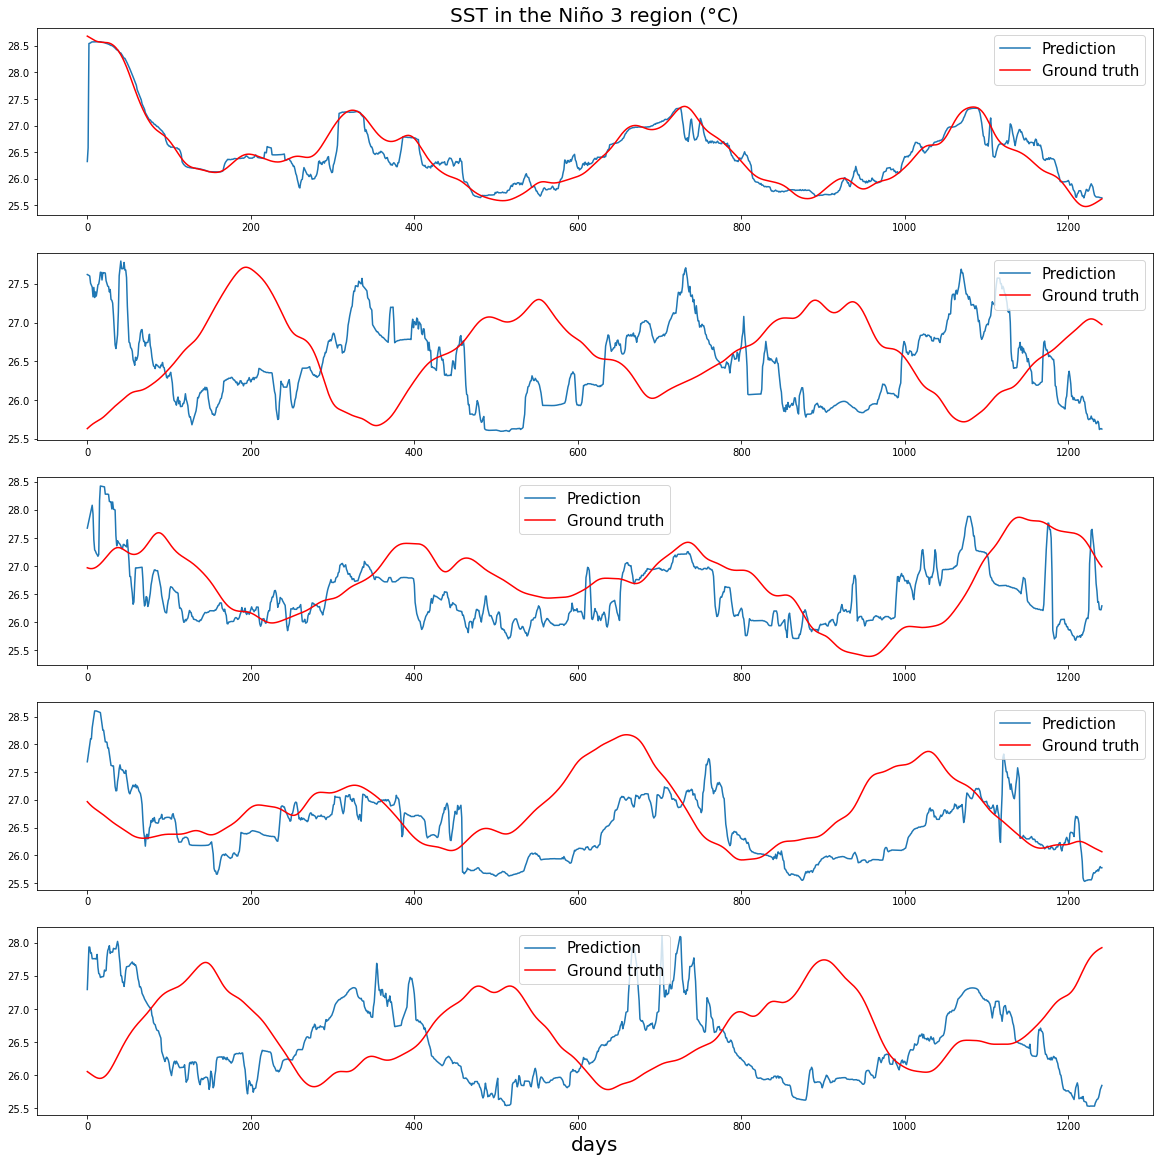

In [ ]:
### Assesing how well our model can generalize 

X1 = X[:1242]      # 1998-2001 : 1 Fort Niño + 2 Moderate Niña
X2 = X[1242:2484]  # 2001-2004 : Nothing really powerful
X3 = X[2484:3726]  # 2004-2008 : Some moderate events 
X4 = X[3726:4968]  # 2008-2011 : 1 Fort Niño + 1 Fort Niña 
X5= X[4968:6210]   # 2011-2014 : Nothing really 

# Compute the predictions for each subset

Y1_pred = KAF(X1,n,T)
Y1_truth = X[T:1242+T]
Y2_pred = KAF(X2,n,T)
Y2_truth = X[1242+T:2484+T]
Y3_pred = KAF(X3,n,T)
Y3_truth = X[2484+T:3726+T]
Y4_pred = KAF(X4,n,T)
Y4_truth = X[3726+T:4968+T]
Y5_pred = KAF(X5,n,T)
Y5_truth = X[4968+T:6210+T]

# Compute the RMSE values

rmse1 = RMSE(Y1_pred,Y1_truth)
rmse2 = RMSE(Y2_pred,Y2_truth)
rmse3 = RMSE(Y3_pred,Y3_truth)
rmse4 = RMSE(Y4_pred,Y4_truth)
rmse5 = RMSE(Y5_pred,Y5_truth)

print("The average RMSE is",mean([rmse1,rmse2,rmse3,rmse4,rmse5]))

# "Denormalize" the data

Y1_pred_denorm = denorm(Y1_pred,abs,ord)
Y2_pred_denorm = denorm(Y2_pred,abs,ord)
Y3_pred_denorm = denorm(Y3_pred,abs,ord)
Y4_pred_denorm = denorm(Y4_pred,abs,ord)
Y5_pred_denorm = denorm(Y5_pred,abs,ord)

Y1_truth_denorm = denorm(Y1_truth,abs,ord)
Y2_truth_denorm = denorm(Y2_truth,abs,ord)
Y3_truth_denorm = denorm(Y3_truth,abs,ord)
Y4_truth_denorm = denorm(Y4_truth,abs,ord)
Y5_truth_denorm = denorm(Y5_truth,abs,ord)

# Plot the predictions for each subset
figure()
subplots()
subplot(5,1,1)
title("SST in the Niño 3 region (°C)",fontsize="20")
plot_sst(Y1_pred_denorm,Y1_truth_denorm)
subplot(5,1,2)
plot_sst(Y2_pred_denorm,Y2_truth_denorm)
subplot(5,1,3)
plot_sst(Y3_pred_denorm,Y3_truth_denorm)
subplot(5,1,4)
plot_sst(Y4_pred_denorm,Y4_truth_denorm)
subplot(5,1,5)
plot_sst(Y5_pred_denorm,Y5_truth_denorm)
xlabel("days",fontsize="20")


Our predictions are biased by the fact that close points in time are taken into account when we search for the nearest neighbors of a particular point. 

So we tune a bit our model, and make a second try :

In [ ]:
# Test the model on a subset of our data
n = 20
T = 180

#X_test = X[4500:6392]
#X_test_indices = np.arange(4500,6392)
#Y_truth = X[4500+180:6392+180]

def KAF_2(X_train,X_test,n,T):
  Y_pred = []

  for i in range(len(X_test)):
    #Find the analogs for each sample of the testing set among the samples of the training set :
    index_knn,dist_knn = nearest_neighbors_kdtree(X_test[i],X_train,n,T)

    # Compute the prediction based on the weighted successors :
    y = np.zeros(2)
    coeff_kernel = statistics.median(dist_knn)
    for i in range(len(index_knn)):
      y += exp(-dist_knn[i]/coeff_kernel*0.001)*X[index_knn[i]+T]  # exp(-dist_knn[i]**2/coeff_kernel**2)*X[index_knn[i]+T] 
    y = y/len(index_knn)

    Y_pred.append(y)
    #Y_truth.append(X[X_test_indices[i]+T])
  return Y_pred

The average RMSE is 6.6695016111391565


Text(0.5, 0, 'days')

<Figure size 1440x1440 with 0 Axes>

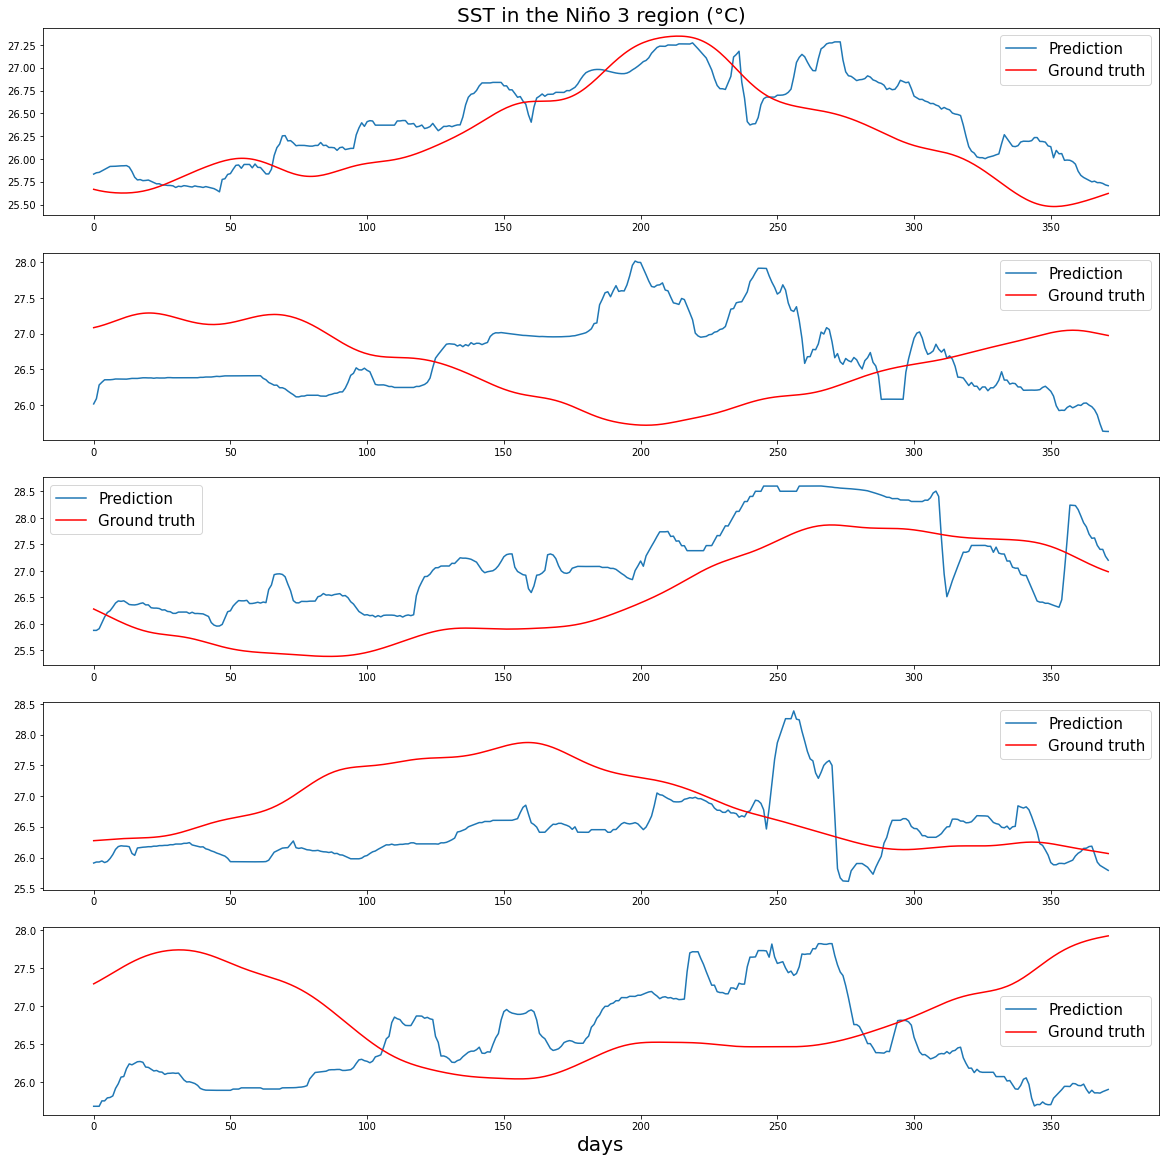

In [ ]:
# Redefine the dataset 

X1_train = X[:870]      # 1998-2001 : 1 Fort Niño + 2 Moderate Niña
X1_test = X[870:1242]
X2_train = X[1242:2112] # 2001-2004 : Nothing really powerful
X2_test = X[2112:2484]   
X3_train = X[2484:3354] # 2004-2008 : Some moderate events 
X3_test =X[3354:3726]  
X4_train = X[3726:4596] # 2008-2011 : 1 Fort Niño + 1 Fort Niña 
X4_test = X[4596:4968]  
X5_train = X[4968:5838]  # 2011-2014 : Nothing really 
X5_test = X[5838:6210]  

# Compute the predictions for each subset

Y1_pred = KAF_2(X1_train,X1_test,n,T)
Y1_truth = X[870+T:1242+T]
Y2_pred = KAF_2(X2_train,X2_test,n,T)
Y2_truth = X[2112+T:2484+T]
Y3_pred = KAF_2(X3_train,X3_test,n,T)
Y3_truth = X[3354+T:3726+T]
Y4_pred = KAF_2(X4_train,X4_test,n,T)
Y4_truth = X[4596+T:4968+T]
Y5_pred = KAF_2(X5_train,X5_test,n,T)
Y5_truth = X[5838+T:6210+T]

# Compute the RMSE values

rmse1 = RMSE(Y1_pred,Y1_truth)
rmse2 = RMSE(Y2_pred,Y2_truth)
rmse3 = RMSE(Y3_pred,Y3_truth)
rmse4 = RMSE(Y4_pred,Y4_truth)
rmse5 = RMSE(Y5_pred,Y5_truth)

print("The average RMSE is",mean([rmse1,rmse2,rmse3,rmse4,rmse5]))

# "Denormalize" the data

Y1_pred_denorm = denorm(Y1_pred,abs,ord)
Y2_pred_denorm = denorm(Y2_pred,abs,ord)
Y3_pred_denorm = denorm(Y3_pred,abs,ord)
Y4_pred_denorm = denorm(Y4_pred,abs,ord)
Y5_pred_denorm = denorm(Y5_pred,abs,ord)

Y1_truth_denorm = denorm(Y1_truth,abs,ord)
Y2_truth_denorm = denorm(Y2_truth,abs,ord)
Y3_truth_denorm = denorm(Y3_truth,abs,ord)
Y4_truth_denorm = denorm(Y4_truth,abs,ord)
Y5_truth_denorm = denorm(Y5_truth,abs,ord)

# Plot the predictions for each subset
figure()
subplots()
subplot(5,1,1)
title("SST in the Niño 3 region (°C)",fontsize="20")
plot_sst(Y1_pred_denorm,Y1_truth_denorm)
subplot(5,1,2)
plot_sst(Y2_pred_denorm,Y2_truth_denorm)
subplot(5,1,3)
plot_sst(Y3_pred_denorm,Y3_truth_denorm)
subplot(5,1,4)
plot_sst(Y4_pred_denorm,Y4_truth_denorm)
subplot(5,1,5)
plot_sst(Y5_pred_denorm,Y5_truth_denorm)
xlabel("days",fontsize="20")


The results are satisfying but there is not enough data represented to get a really good idea of how well our model works.

So we make a last try at our model with 1998 to 2010 data as training and try to make a prediction for 2010 to 2015.

The RMSE is 9.188011721193568


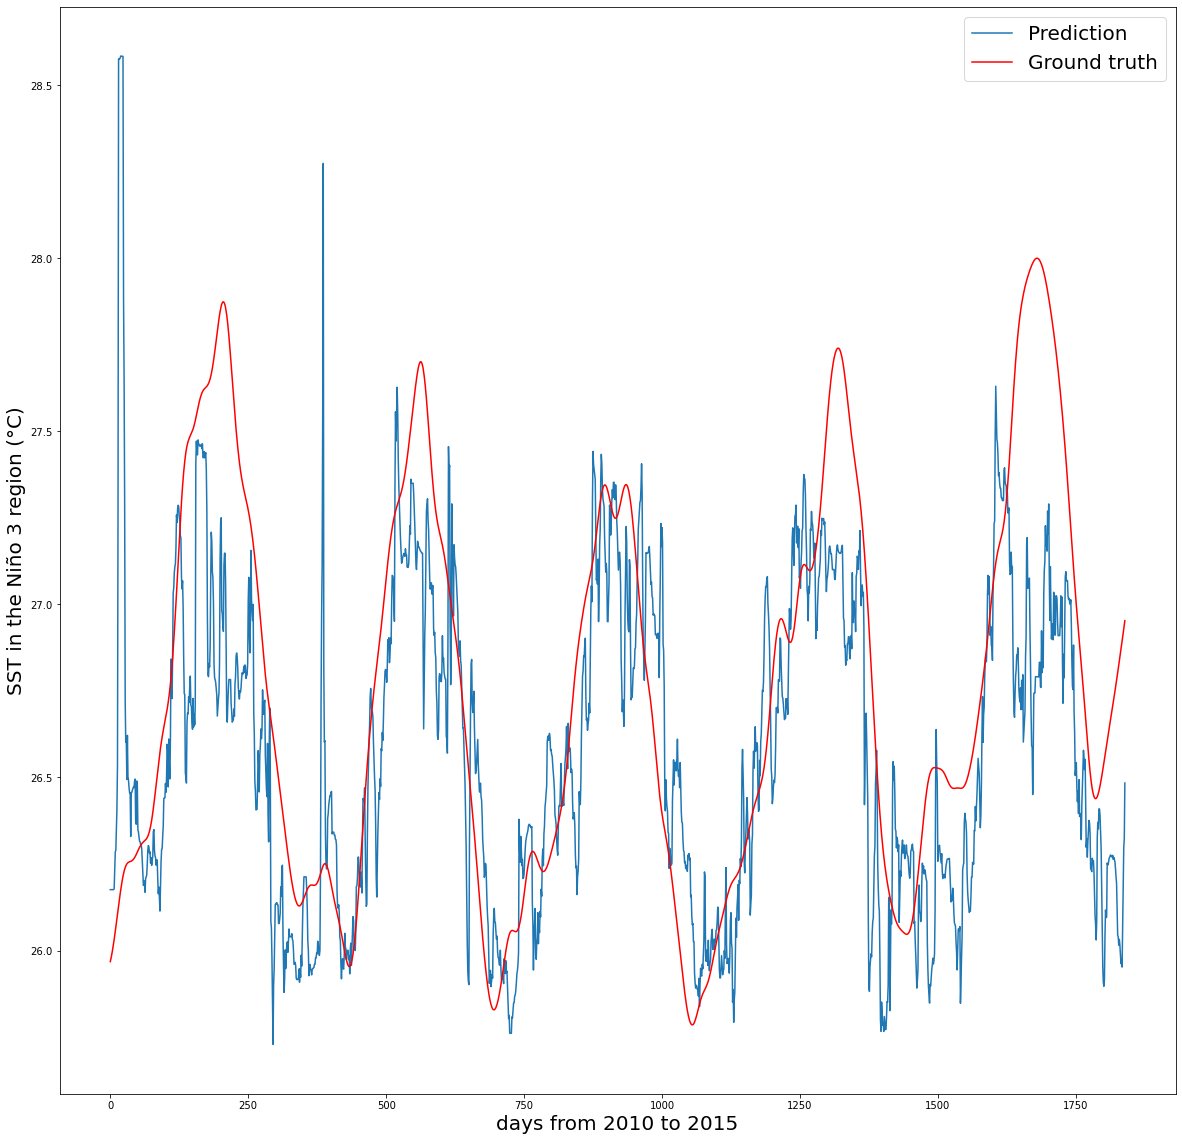

In [ ]:
X_train = X[:4550]  # until 2010
X_test = X[4550:6390]  

Y_pred = KAF_2(X_train,X_test,n,T)
Y_truth = X[4550+T:6390+T]

rmse=RMSE(Y_pred,Y_truth)
print("The RMSE is",rmse)

Y_pred = denorm(Y_pred,abs,ord)
Y_truth = denorm(Y_truth,abs,ord)

sst_pred = []
sst_truth = []
for i in range(len(Y_pred)):
  sst_pred.append(Y_pred[i][0])
  sst_truth.append(Y_truth[i][0])

plot(sst_pred,label="Prediction")
plot(sst_truth,'r',label="Ground truth")
ylabel("SST in the Niño 3 region (°C)",fontsize="20")
xlabel("days from 2010 to 2015",fontsize="20")
legend(fontsize="20")